# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 4  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 30000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 4]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 544.1508178710938
iteration 0 loss 184.27146911621094


iteration 500 loss 23.251771926879883


iteration 1000 loss 18.811458587646484


iteration 1500 loss 13.790462493896484


iteration 2000 loss 7.4497575759887695


iteration 2500 loss 1.9817818403244019


iteration 3000 loss 0.5754455924034119


iteration 3500 loss 0.3028204143047333


iteration 4000 loss 0.17595696449279785


iteration 4500 loss 0.10661109536886215


iteration 5000 loss 0.07029293477535248


iteration 5500 loss 0.050435300916433334


iteration 6000 loss 0.03837341070175171


iteration 6500 loss 0.030356066301465034


iteration 7000 loss 0.024596551433205605


iteration 7500 loss 0.020204870030283928


iteration 8000 loss 0.016849171370267868


iteration 8500 loss 0.014296379871666431


iteration 9000 loss 0.012659098021686077


iteration 9500 loss 0.011187280528247356


iteration 10000 loss 0.009860514663159847


iteration 10500 loss 0.009200742468237877


iteration 11000 loss 0.008572747930884361


iteration 11500 loss 0.007912253960967064


iteration 12000 loss 0.007226844783872366


iteration 12500 loss 0.0068947249092161655


iteration 13000 loss 0.00656840018928051


iteration 13500 loss 0.006201026029884815


iteration 14000 loss 0.005791535135358572


iteration 14500 loss 0.005567531567066908


iteration 15000 loss 0.005317146889865398


iteration 15500 loss 0.005164578557014465


iteration 16000 loss 0.004833616316318512


iteration 16500 loss 0.004623000044375658


iteration 17000 loss 0.004461951553821564


iteration 17500 loss 0.004280992783606052


iteration 18000 loss 0.00416759867221117


iteration 18500 loss 0.0040406715124845505


iteration 19000 loss 0.003914051689207554


iteration 19500 loss 0.003824792103841901


iteration 20000 loss 0.0037292735651135445


iteration 20500 loss 0.003615093883126974


iteration 21000 loss 0.0035397077444940805


iteration 21500 loss 0.0034692909102886915


iteration 22000 loss 0.0033840094693005085


iteration 22500 loss 0.00330536300316453


iteration 23000 loss 0.0032480391673743725


iteration 23500 loss 0.0031782696023583412


iteration 24000 loss 0.003107476281002164


iteration 24500 loss 0.0030623720958828926


iteration 25000 loss 0.0030122091993689537


iteration 25500 loss 0.002951063448563218


iteration 26000 loss 0.0028958753682672977


iteration 26500 loss 0.0028407680802047253


iteration 27000 loss 0.002804133342579007


iteration 27500 loss 0.0027599979657679796


iteration 28000 loss 0.002706235507503152


iteration 28500 loss 0.0026753218844532967


iteration 29000 loss 0.0026435870677232742


iteration 29500 loss 0.0026046736165881157


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=4) ---
loss 23.853437423706055


loss -21.071142196655273


loss -46.369903564453125


loss -55.98308563232422


loss -58.96931838989258


loss -59.94378662109375


loss -60.263614654541016


loss -60.35491180419922


loss -60.375144958496094


loss -60.378238677978516


loss -60.378517150878906


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.3785285949707


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.3785285949707


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.3785285949707


loss -60.37853240966797


loss -60.3785285949707


loss -60.37853240966797


loss -60.37853240966797


loss -60.37853240966797


loss -60.3785285949707


loss -60.37853240966797


final mse:  2.282117606000611e-09
max, min: 1.9608047 -2.034608
loss 23.853437423706055


loss -21.767597198486328


loss -47.342735290527344


loss -57.7661247253418


loss -61.155704498291016


loss -62.21031951904297


loss -62.513736724853516


loss -62.584312438964844


loss -62.5960693359375


loss -62.59730529785156


loss -62.59737014770508


loss -62.597381591796875


loss -62.597373962402344


loss -62.597373962402344


loss -62.597373962402344


loss -62.597373962402344


loss -62.59737014770508


loss -62.597373962402344


loss -62.597373962402344


loss -62.597381591796875


loss -62.597381591796875


loss -62.59737777709961


loss -62.59737014770508


loss -62.597373962402344


loss -62.59737014770508


loss -62.597373962402344


loss -62.597381591796875


loss -62.597373962402344


loss -62.597373962402344


loss -62.597381591796875


loss -62.597381591796875


loss -62.597381591796875


loss -62.597373962402344


loss -62.597381591796875


loss -62.597373962402344


loss -62.597381591796875


loss -62.597373962402344


loss -62.597381591796875


loss -62.597381591796875


loss -62.597381591796875


final mse:  2.8479647529167096e-09
max, min: 1.9597996 -1.9745972


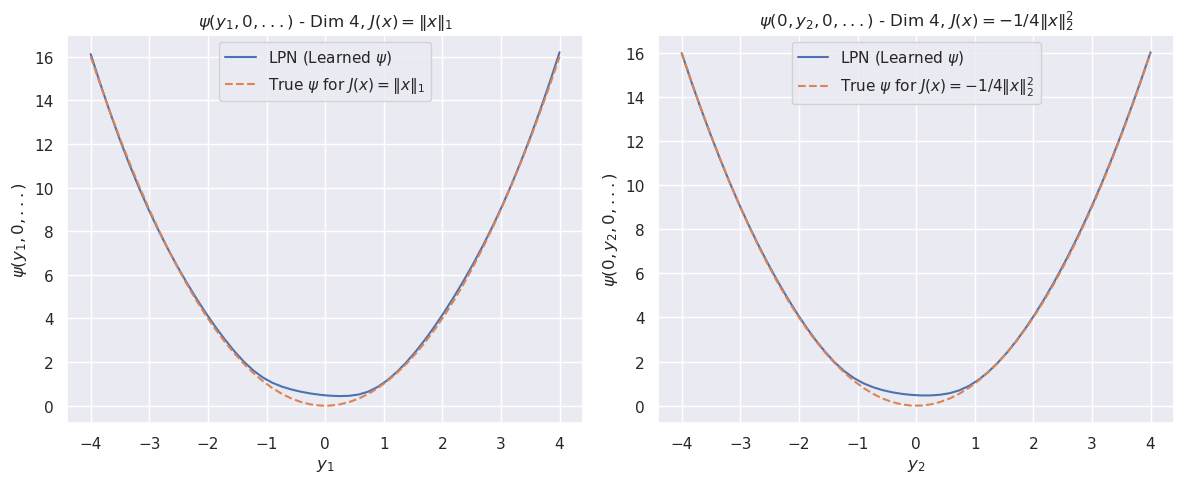

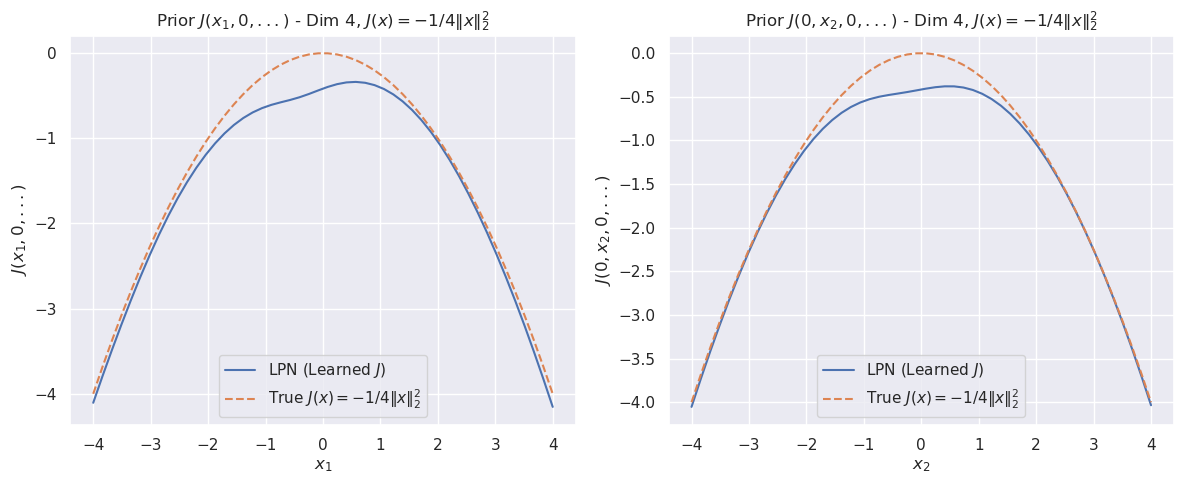

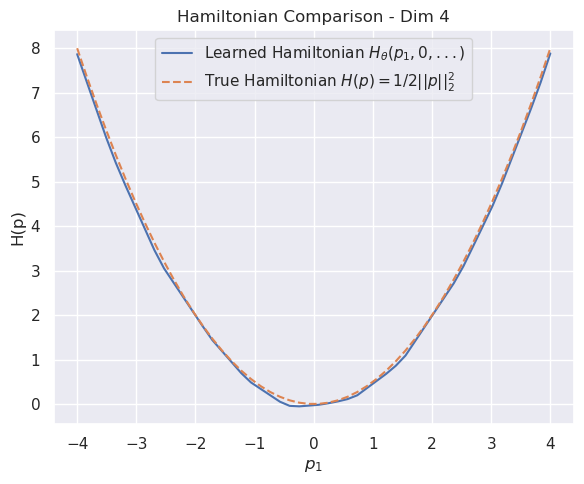

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=4) ---


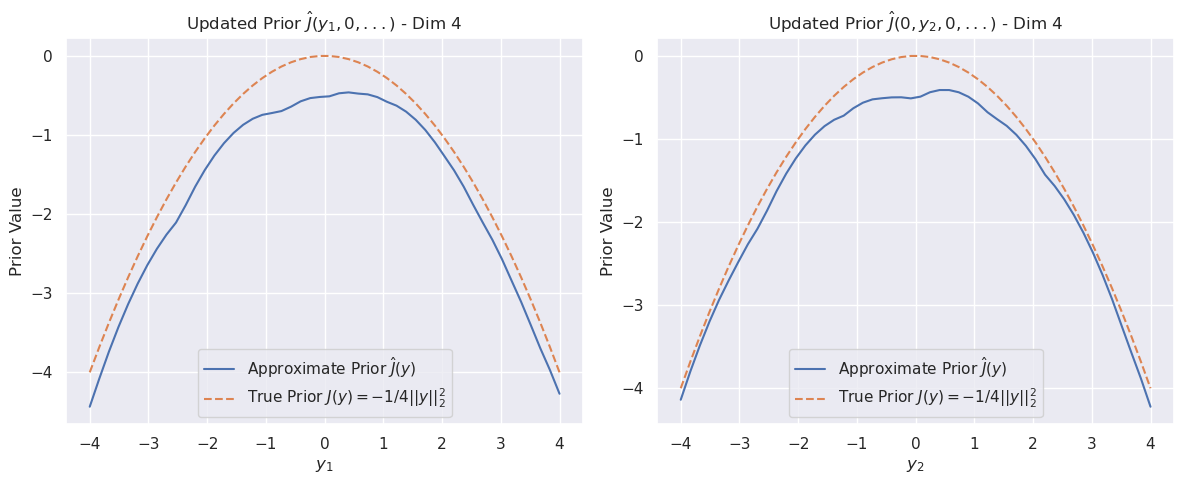

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = y_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 537.5604248046875
iteration 0 loss 58.96197509765625


iteration 500 loss 18.835264205932617


iteration 1000 loss 14.595218658447266


iteration 1500 loss 9.40139389038086


iteration 2000 loss 3.6448066234588623


iteration 2500 loss 0.8688801527023315


iteration 3000 loss 0.3271934986114502


iteration 3500 loss 0.1721842736005783


iteration 4000 loss 0.10839733481407166


iteration 4500 loss 0.07523512840270996


iteration 5000 loss 0.056048911064863205


iteration 5500 loss 0.04442736133933067


iteration 6000 loss 0.03662658482789993


iteration 6500 loss 0.031825728714466095


iteration 7000 loss 0.027674248442053795


iteration 7500 loss 0.023907432332634926


iteration 8000 loss 0.020620020106434822


iteration 8500 loss 0.019160350784659386


iteration 9000 loss 0.017832832410931587


iteration 9500 loss 0.01652269810438156


iteration 10000 loss 0.015228047966957092


iteration 10500 loss 0.01421031728386879


iteration 11000 loss 0.013433370739221573


iteration 11500 loss 0.012598772533237934


iteration 12000 loss 0.011828468181192875


iteration 12500 loss 0.011477267369627953


iteration 13000 loss 0.011084118857979774


iteration 13500 loss 0.010639797896146774


iteration 14000 loss 0.010142439045011997


iteration 14500 loss 0.009830101393163204


iteration 15000 loss 0.009627040475606918


iteration 15500 loss 0.00938849151134491


iteration 16000 loss 0.00911202747374773


iteration 16500 loss 0.008805259130895138


iteration 17000 loss 0.008624947629868984


iteration 17500 loss 0.00842367485165596


iteration 18000 loss 0.008187678642570972


iteration 18500 loss 0.008051373064517975


iteration 19000 loss 0.007915455847978592


iteration 19500 loss 0.007753534708172083


iteration 20000 loss 0.0076002865098416805


iteration 20500 loss 0.007497669663280249


iteration 21000 loss 0.007374626584351063


iteration 21500 loss 0.007241637911647558


iteration 22000 loss 0.007139336317777634


iteration 22500 loss 0.007016992196440697


iteration 23000 loss 0.006908483803272247


iteration 23500 loss 0.006793315056711435


iteration 24000 loss 0.006712934002280235


iteration 24500 loss 0.006618867162615061


iteration 25000 loss 0.006503849755972624


iteration 25500 loss 0.0064392006024718285


iteration 26000 loss 0.006378219462931156


iteration 26500 loss 0.006303178146481514


iteration 27000 loss 0.011203192174434662


iteration 27500 loss 0.0061484635807573795


iteration 28000 loss 0.006070106290280819


iteration 28500 loss 0.005999410059303045


iteration 29000 loss 0.005923361051827669


iteration 29500 loss 0.0058608283288776875


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


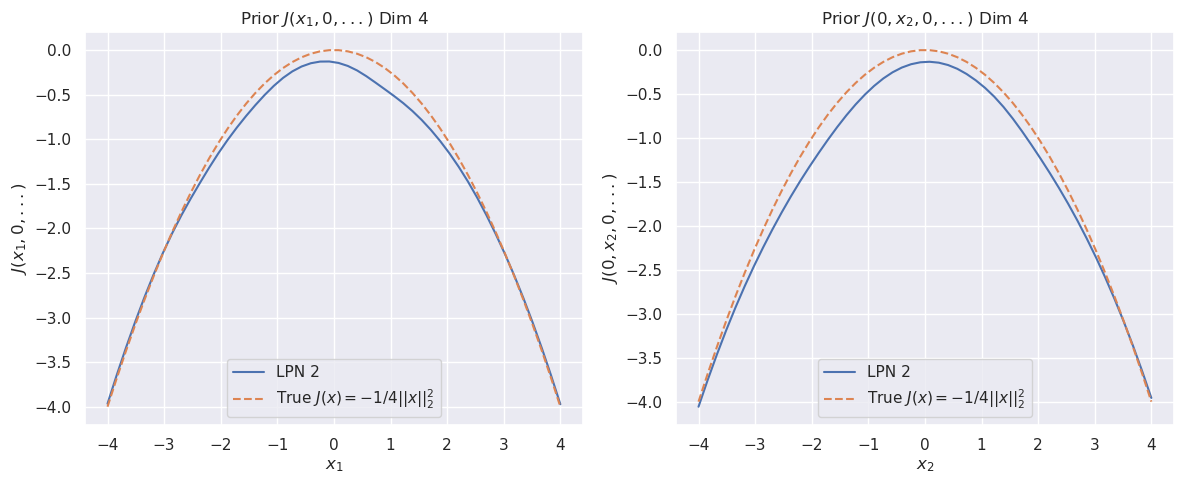

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [12]:

# --- Train and Plot with L1 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 563.7821655273438


iteration 500 loss 21.060972213745117


iteration 0 loss 15.179512023925781


iteration 500 loss 8.465081214904785


iteration 1000 loss 2.426973819732666


iteration 1500 loss 0.6156308650970459


iteration 2000 loss 0.3149440288543701


iteration 2500 loss 0.17931796610355377


iteration 3000 loss 0.11007992923259735


iteration 3500 loss 0.07392734289169312


iteration 4000 loss 0.053782541304826736


iteration 4500 loss 0.041366174817085266


iteration 5000 loss 0.03243467956781387


iteration 5500 loss 0.025679057464003563


iteration 6000 loss 0.020633826032280922


iteration 6500 loss 0.01689641922712326


iteration 7000 loss 0.014143450185656548


iteration 7500 loss 0.012404079549014568


iteration 8000 loss 0.010862207971513271


iteration 8500 loss 0.009540533646941185


iteration 9000 loss 0.008874787949025631


iteration 9500 loss 0.008196952752768993


iteration 10000 loss 0.007525109685957432


iteration 10500 loss 0.009442863054573536


iteration 11000 loss 0.0065820724703371525


iteration 11500 loss 0.006252215709537268


iteration 12000 loss 0.005893161986023188


iteration 12500 loss 0.005643659271299839


iteration 13000 loss 0.005459028296172619


iteration 13500 loss 0.005247112363576889


iteration 14000 loss 0.005007320083677769


iteration 14500 loss 0.004863247741013765


iteration 15000 loss 0.004707246087491512


iteration 15500 loss 0.004526757635176182


iteration 16000 loss 0.004427493084222078


iteration 16500 loss 0.00432116212323308


iteration 17000 loss 0.004193984903395176


iteration 17500 loss 0.004075485747307539


iteration 18000 loss 0.003981862682849169


iteration 18500 loss 0.003868976142257452


iteration 19000 loss 0.003782736836001277


iteration 19500 loss 0.0036918814294040203


iteration 20000 loss 0.003603945719078183


iteration 20500 loss 0.003539387369528413


iteration 21000 loss 0.003461146028712392


iteration 21500 loss 0.003382266266271472


iteration 22000 loss 0.0033330528531223536


iteration 22500 loss 0.0032739622984081507


iteration 23000 loss 0.014602025970816612


iteration 23500 loss 0.0031522661447525024


iteration 24000 loss 0.003091582329943776


iteration 24500 loss 0.0030386599246412516


iteration 25000 loss 0.002990220906212926


iteration 25500 loss 0.0029326011426746845


iteration 26000 loss 0.0028940741904079914


iteration 26500 loss 0.0028496955055743456


iteration 27000 loss 0.0028111375868320465


iteration 27500 loss 0.002766927471384406


iteration 28000 loss 0.0027270836289972067


iteration 28500 loss 0.002684683073312044


iteration 29000 loss 0.0026522926054894924


iteration 29500 loss 0.0026125868316739798


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=4) ---
loss 13.98025894165039


loss -27.8973445892334


loss -50.39955139160156


loss -59.67422866821289


loss -62.9396858215332


loss -64.07015228271484


loss -64.43222045898438


loss -64.5276870727539


loss -64.54718780517578


loss -64.55003356933594


loss -64.55029296875


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030059814453


loss -64.55030059814453


loss -64.55030822753906


loss -64.55030059814453


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030059814453


loss -64.55030059814453


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030059814453


loss -64.55030059814453


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030059814453


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030059814453


loss -64.55030059814453


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030822753906


loss -64.55030059814453


final mse:  5.209122910798669e-09
max, min: 2.0223212 -1.99139
loss 13.98025894165039


loss -29.681198120117188


loss -53.0921516418457


loss -62.529693603515625


loss -65.95783996582031


loss -67.13001251220703


loss -67.4766616821289


loss -67.55728912353516


loss -67.57050323486328


loss -67.57183074951172


loss -67.5718994140625


loss -67.57190704345703


loss -67.57190704345703


loss -67.5718994140625


loss -67.57190704345703


loss -67.5718994140625


loss -67.5718994140625


loss -67.5718994140625


loss -67.5718994140625


loss -67.57190704345703


loss -67.5718994140625


loss -67.5718994140625


loss -67.57190704345703


loss -67.57190704345703


loss -67.57190704345703


loss -67.5718994140625


loss -67.5718994140625


loss -67.5718994140625


loss -67.5718994140625


loss -67.5718994140625


loss -67.5718994140625


loss -67.57190704345703


loss -67.57190704345703


loss -67.57190704345703


loss -67.57190704345703


loss -67.5718994140625


loss -67.57190704345703


loss -67.5718994140625


loss -67.5718994140625


loss -67.57190704345703


final mse:  4.746370851904658e-09
max, min: 2.0044887 -1.9591289


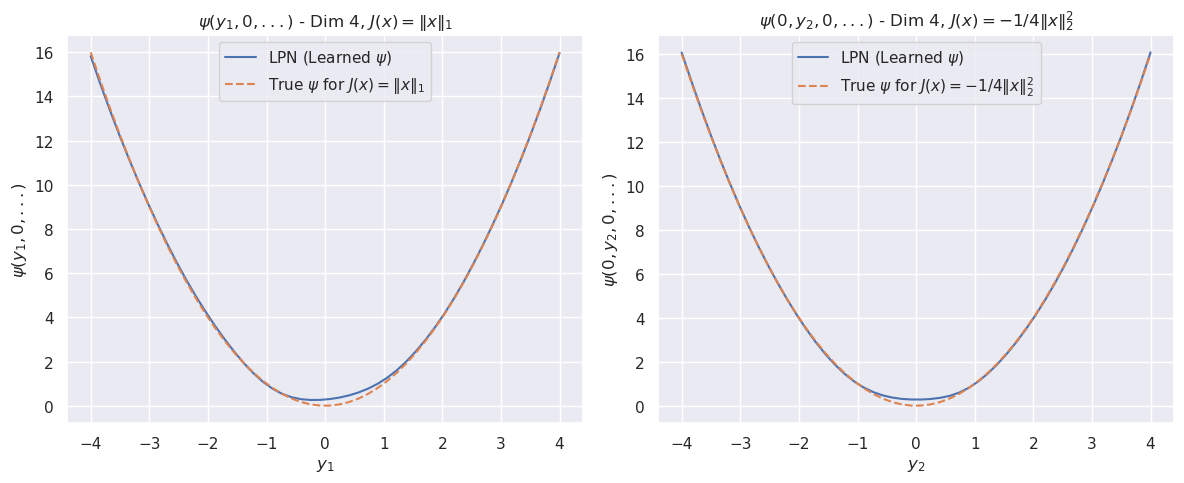

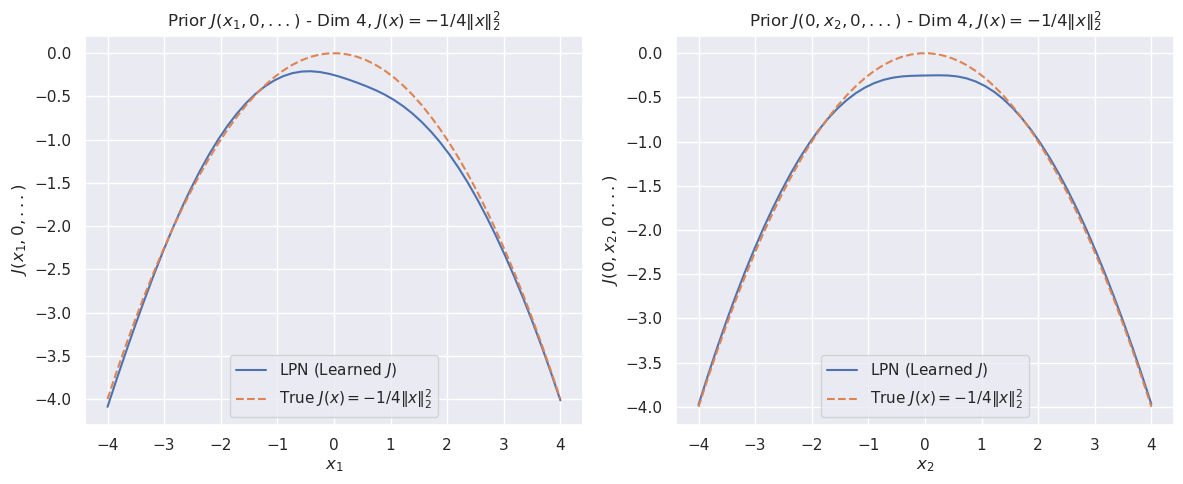

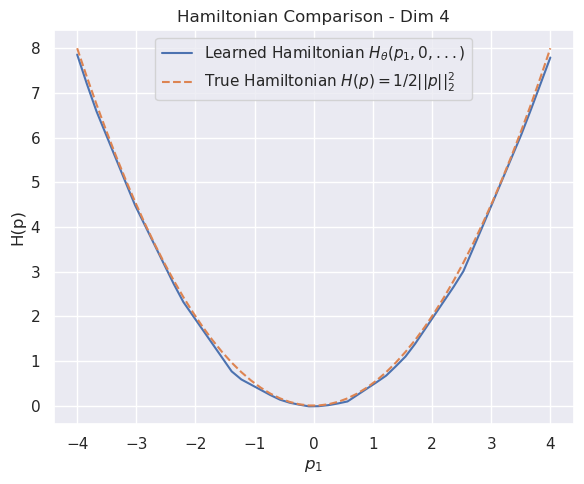

In [13]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)


Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [14]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [15]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [16]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [17]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [18]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [19]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)